# Example training and evaluation of LightGBM model

Download the CESNET-QUIC22 dataset if it is not already downloaded, enable logging, and set configuration.

In [2]:
import os
import logging
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from cesnet_datazoo.datasets import CESNET_QUIC22
from cesnet_datazoo.config import DatasetConfig, ValidationApproach, ScalerEnum, AppSelection

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s][%(name)s][%(levelname)s] - %(message)s")

dataset = CESNET_QUIC22(data_root="data/CESNET-QUIC22/", size="XS")
common_params = {
    "dataset": dataset,
    "apps_selection": AppSelection.ALL_KNOWN,
    "train_period_name": "W-2022-44",
    "val_approach": ValidationApproach.SPLIT_FROM_TRAIN,
    "train_val_split_fraction": 0.2,
    "flowstats_scaler": ScalerEnum.NO_SCALER,
    "psizes_scaler": ScalerEnum.NO_SCALER,
    "ipt_scaler": ScalerEnum.NO_SCALER,
}
dataset_config = DatasetConfig(**common_params)
dataset.set_dataset_config_and_initialize(dataset_config)

[2023-11-01 11:06:21,046][cesnet_datazoo.pytables_data.indices_setup][INFO] - Processing train indices
[2023-11-01 11:06:21,305][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app column for train table /flows/D20221031 took 0.22 seconds
[2023-11-01 11:06:21,536][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app column for train table /flows/D20221101 took 0.23 seconds
[2023-11-01 11:06:21,997][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app column for train table /flows/D20221102 took 0.46 seconds
[2023-11-01 11:06:22,449][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app column for train table /flows/D20221103 took 0.45 seconds
[2023-11-01 11:06:22,811][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app column for train table /flows/D20221104 took 0.36 seconds
[2023-11-01 11:06:22,971][cesnet_datazoo.pytables_data.pytables_dataset][INFO] - Reading app column for train table /flows/D20221105 took 0.16

Load training and validation dataframes and create LightGBM datasets.

In [3]:
import lightgbm as lgb
from cesnet_datazoo.constants import APP_COLUMN

feature_names = dataset_config.get_feature_names(flatten_ppi=True)
train_df = dataset.get_train_df(flatten_ppi=True)
val_df = dataset.get_val_df(flatten_ppi=True)
train_labels = train_df.pop(APP_COLUMN)
val_labels = val_df.pop(APP_COLUMN)

lgb_train_dataset = lgb.Dataset(data=train_df, label=train_labels, feature_name=feature_names)
lgb_val_dataset = lgb.Dataset(data=val_df, label=val_labels, feature_name=feature_names)

print(f"Loaded {len(train_df)} train samples")
print(f"Loaded {len(val_df)} validation samples")

Loading data from dataloader


100%|██████████| 8162/8162 [00:03<00:00, 2056.30it/s]


Loading data from dataloader


100%|██████████| 192/192 [00:01<00:00, 163.20it/s]


Loaded 1566944 train samples
Loaded 391736 validation samples


Train the LightGBM model for 20 iterations.

In [4]:
lgb_params = {
    "task": "train",
    "objective": "multiclass",
    "num_class": dataset.get_num_classes(),
    "metric": "multi_error",
    "num_leaves": 320,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "lambda_l2": 4,
    "verbose": -1,
}

validation_metrics = {}
lgb_model = lgb.train(
    params=lgb_params,
    num_boost_round=20,
    train_set=lgb_train_dataset,
    valid_sets=[lgb_val_dataset],
    callbacks=[lgb.log_evaluation()]
)
best_score = lgb_model.best_score["valid_0"]["multi_error"]
print(f"The best validation score is {best_score:.3f}")

[1]	valid_0's multi_error: 0.228133
[2]	valid_0's multi_error: 0.193135
[3]	valid_0's multi_error: 0.174097
[4]	valid_0's multi_error: 0.162056
[5]	valid_0's multi_error: 0.152087
[6]	valid_0's multi_error: 0.144355
[7]	valid_0's multi_error: 0.138027
[8]	valid_0's multi_error: 0.132896
[9]	valid_0's multi_error: 0.128589
[10]	valid_0's multi_error: 0.124964
[11]	valid_0's multi_error: 0.121847
[12]	valid_0's multi_error: 0.118782
[13]	valid_0's multi_error: 0.115889
[14]	valid_0's multi_error: 0.113615
[15]	valid_0's multi_error: 0.111396
[16]	valid_0's multi_error: 0.109313
[17]	valid_0's multi_error: 0.107475
[18]	valid_0's multi_error: 0.105816
[19]	valid_0's multi_error: 0.10406
[20]	valid_0's multi_error: 0.102602
The best validation score is 0.103


## Per-week evaluation

Training of the model was done on samples of the first (44th week of 2022) week of CESNET-QUIC22. Now, let's evaluate the model on the following three weeks (45th, 46th, and 47th).

For each week:

1. Create ``DatasetConfig`` and set the week as ``test_period_name``
2. Load test dataframe
3. Predict applications with the trained LightGBM model
4. Compute classification accuracy


Testing on period W-2022-45
Loading data from dataloader


100%|██████████| 1247/1247 [00:15<00:00, 81.02it/s] 


Loaded 2551901 test samples
Classification accuracy for W-2022-45 is 0.820

Testing on period W-2022-46
Loading data from dataloader


100%|██████████| 985/985 [00:13<00:00, 75.36it/s] 


Loaded 2016733 test samples
Classification accuracy for W-2022-46 is 0.735

Testing on period W-2022-47
Loading data from dataloader


100%|██████████| 1289/1289 [00:15<00:00, 81.54it/s] 


Loaded 2639441 test samples
Classification accuracy for W-2022-47 is 0.725


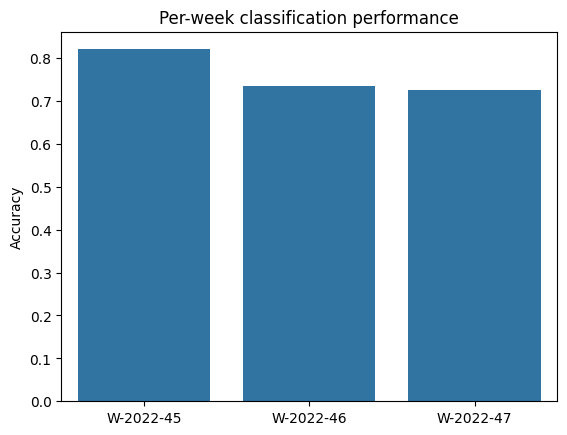

In [5]:
from sklearn.metrics import accuracy_score
import seaborn

test_periods = ["W-2022-45", "W-2022-46", "W-2022-47"]
per_week_acc = []
for period in test_periods:
    print(f"\nTesting on period {period}")
    dataset_config = DatasetConfig(**common_params, test_period_name=period)
    dataset.set_dataset_config_and_initialize(dataset_config)
    test_df = dataset.get_test_df(flatten_ppi=True)
    print(f"Loaded {len(test_df)} test samples")
    test_labels = test_df.pop(APP_COLUMN)
    preds = lgb_model.predict(test_df).argmax(axis=1)
    acc = accuracy_score(test_labels, preds)
    per_week_acc.append(acc)
    print(f"Classification accuracy for {period} is {acc:.3f}")

seaborn.barplot(y=per_week_acc, x=test_periods).set(title="Per-week classification performance", ylabel="Accuracy");


## Per-day evaluation
Per-week evaluation might be too coarse-grained. Compute per-day performance. The big performance drop is related to a change of Google certificate and is discussed more in the *Encrypted traffic classification: the QUIC case* paper.

In [1]:
test_dates = ["20221107", "20221108", "20221109", "20221110", "20221111", "20221112", "20221113",
              "20221114", "20221115", "20221116", "20221117", "20221118", "20221119", "20221120",
              "20221121", "20221122", "20221123", "20221124", "20221125", "20221126", "20221127"]
per_date_acc = []
for date in test_dates:
    dataset_config = DatasetConfig(**common_params, test_period_name=date)
    dataset.set_dataset_config_and_initialize(dataset_config)
    test_df = dataset.get_test_df(flatten_ppi=True)
    test_labels = test_df.pop(APP_COLUMN)
    preds = lgb_model.predict(test_df).argmax(axis=1)
    acc = accuracy_score(test_labels, preds)
    per_date_acc.append(acc)

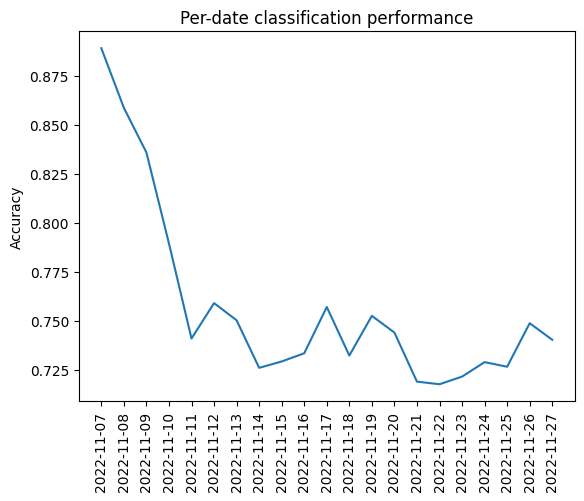

In [8]:
from matplotlib import pyplot as plt

x_labels = list(map(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:]}", test_dates))
fig, ax = plt.subplots()
seaborn.lineplot(x=range(len(per_date_acc)), y=per_date_acc, ax=ax)
ax.set_xticks(range(len(per_date_acc)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_ylabel("Accuracy")
ax.set(title="Per-date classification performance");